In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch.nn as nn
import torch
import idx2numpy 
from torchvision.transforms.functional import gaussian_blur
from torch import optim

from matplotlib import pyplot as plt
from deepshape.surfaces import * 

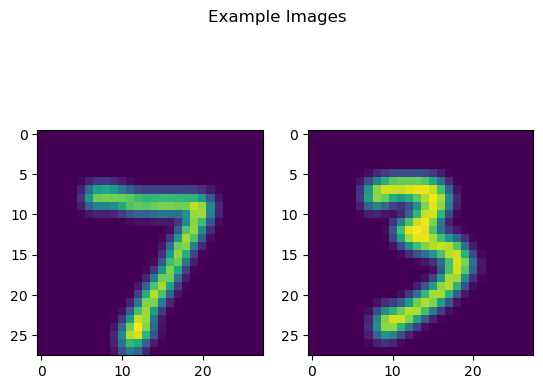

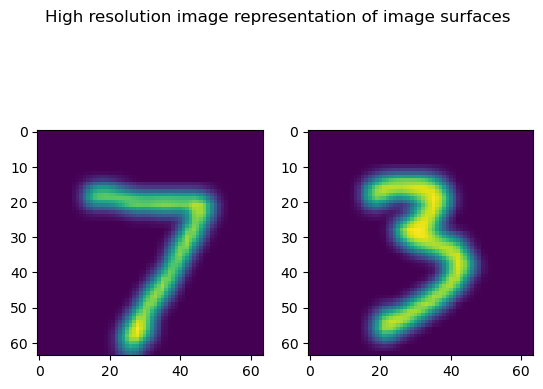

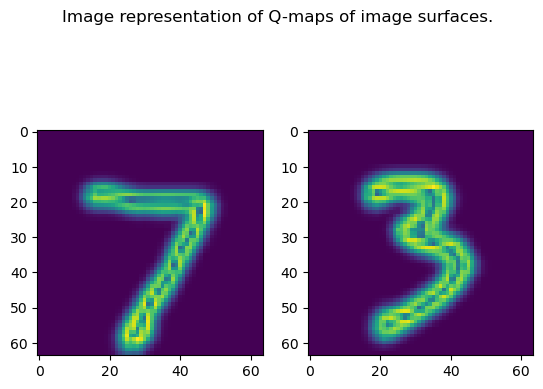

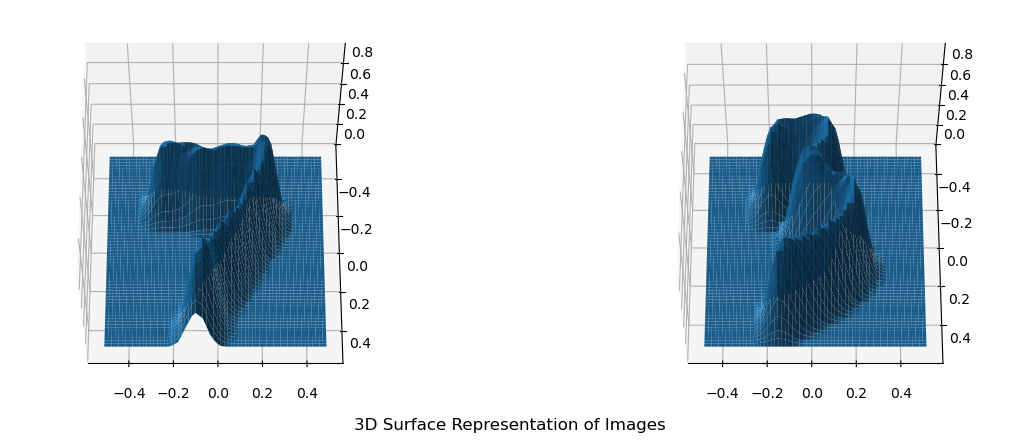

In [81]:
# Load Data
imgfile = "../data/t10k-images.idx3-ubyte"
imgdata = torch.tensor( idx2numpy.convert_from_file(imgfile), dtype=torch.float )
labelfile = "../data/t10k-labels.idx1-ubyte"
labels = torch.tensor( idx2numpy.convert_from_file(labelfile))
imgdata = gaussian_blur(imgdata, [3, 3])
imgdata /= imgdata.max()

# Extract example images
img1 = imgdata[0]
img2 = imgdata[30]

fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(img1)
ax2.imshow(img2)
plt.suptitle("Example Images")
plt.show()

# Create surface representation of images
f = SingleChannelImageSurface(img1, centering=True, scaled=True, mode='bicubic')
g = SingleChannelImageSurface(img2, centering=True, scaled=True, mode='bicubic')

# Find example data of surface representations of the images.
k = 64
XX = torch_square_grid(k=k)
X = XX.view(-1, 2)
Zf = f(XX).permute(2, 0, 1).numpy()
Zg = g(XX).permute(2, 0, 1).numpy()

# Plotting
fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(Zf[2])
ax2.imshow(Zg[2])
plt.suptitle("High resolution image representation of image surfaces")
plt.show()

# Create sample data of Q-map representations of the images.
q = Qmap(f)
r = Qmap(g)
Zq = q(XX).permute(2, 0, 1).numpy()
Zr = r(XX).permute(2, 0, 1).numpy()

# Plot the q-map representation as images.
fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(Zq[2])
ax2.imshow(Zr[2])
plt.suptitle("Image representation of Q-maps of image surfaces.")
plt.show()


# 3D-plot of the surface representation of the images. 
fig = plt.figure(figsize=(12, 4))
fig.suptitle("3D Surface Representation of Images")
ax = plt.axes((0., 1., 0.5, 1.), projection='3d')
ax.plot_surface(*Zf, rstride=1, cstride=1)
ax.view_init(+60, -270)
ax.invert_xaxis()

ax = plt.axes((0.5, 1., 0.5, 1.), projection='3d')
ax.plot_surface(*Zg, rstride=1, cstride=1)
ax.view_init(+60, -270)
ax.invert_xaxis()
plt.show(fig)

[Iter     1] loss: 0.383045
Epoch     5: reducing learning rate of group 0 to 5.0000e-02.
[Iter     6] loss: 0.430740
[Iter    11] loss: 0.267668
[Iter    16] loss: 0.261230
[Iter    21] loss: 0.191754
[Iter    26] loss: 0.290042
Epoch    27: reducing learning rate of group 0 to 2.5000e-02.
[Iter    31] loss: 0.168469
[Iter    36] loss: 0.179887
[Iter    41] loss: 0.164845
[Iter    46] loss: 0.091562
Epoch    51: reducing learning rate of group 0 to 1.2500e-02.
[Iter    51] loss: 0.141815
[Iter    56] loss: 0.083249
[Iter    61] loss: 0.078060
[Iter    66] loss: 0.081874
Epoch    67: reducing learning rate of group 0 to 6.2500e-03.
[Iter    71] loss: 0.072145
[Iter    76] loss: 0.070342
Epoch    81: reducing learning rate of group 0 to 3.1250e-03.
[Iter    81] loss: 0.068493
[Iter    86] loss: 0.067654
[Iter    91] loss: 0.066809
Epoch    95: reducing learning rate of group 0 to 1.5625e-03.
[Iter    96] loss: 0.066692

Finished training in 22.63036s


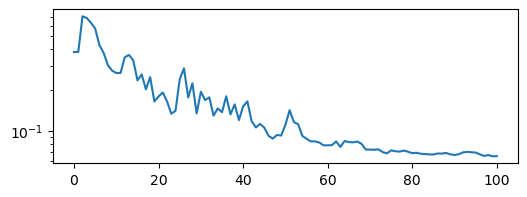

In [87]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

# Define reparametrization-network
RN = SurfaceReparametrizer(
    [PalaisLayer(5, init_scale=0., projection_method="lipschitz") for _ in range(5)]
).to(device)

loss_func = ImageComponentDistance(q, r, k=64, h=1e-4).to(device)
# loss_func = ShapeDistance(q, r, k=64, h=1e-4).to(device)

# Define optimizer and learning rate scheduler
optimizer = optim.LBFGS(RN.parameters(), lr=1., max_iter=100, line_search_fn="strong_wolfe")
optimizer = optim.SGD(RN.parameters(), lr=1e-1, momentum=0.5)
schedular=None
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, threshold=0.,
    threshold_mode='rel', cooldown=10, min_lr=1e-4, eps=1e-08,
    verbose=True)

# Train and store convergence
errors = reparametrize(RN, loss_func, optimizer, 100, Logger(5), projection_kwargs={"epsilon": 1e-2}, scheduler=scheduler)

RN.to("cpu"), loss_func.to("cpu");

plt.figure(figsize=(6, 2))
plt.semilogy(errors)
plt.show()

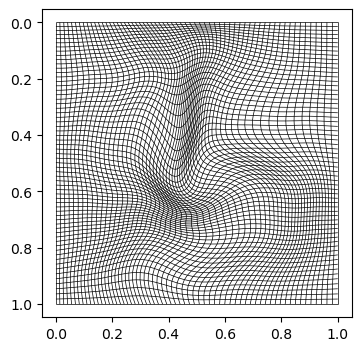

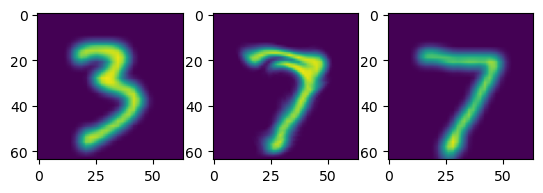

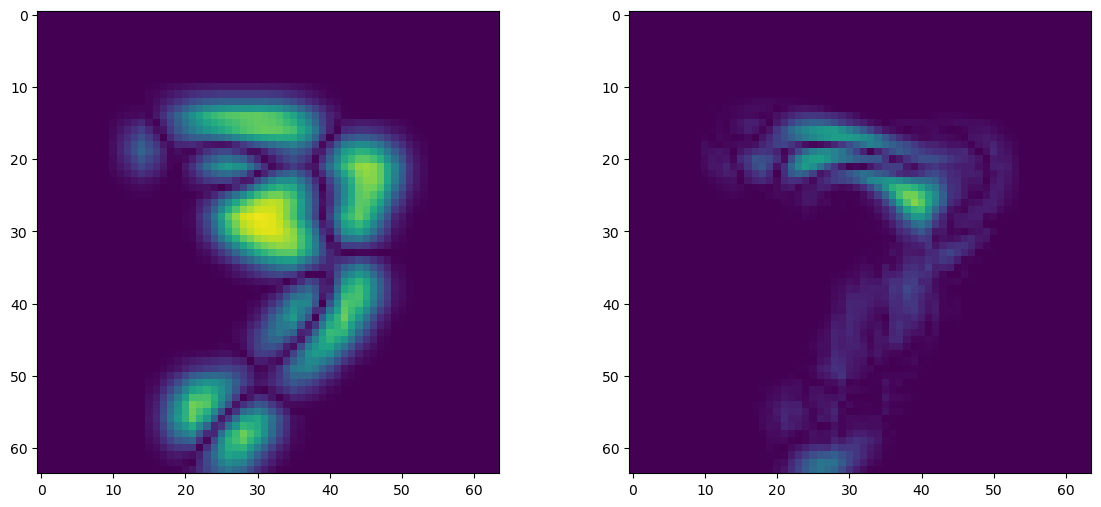

In [88]:
# =============== PLotting below +============
u = lambda x: RN(x)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_diffeomorphism(u, k=64, ax=ax, color="k", lw=0.5)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.gca().invert_yaxis()
plt.axis("equal")
plt.savefig("/home/jorgen/deepshape/figures/1-2-warp-diffeomorphism.pdf")


fphi = f.compose(u)
gphi = g.compose(u)

Zff = fphi(X).view(k, k, 3).detach().numpy()
Zgg = gphi(X).view(k, k, 3).detach().numpy()

fig, (ax1, ax2 , ax3)= plt.subplots(1, 3)
ax3.imshow(Zf[2], vmin=0., vmax=1.)
ax2.imshow(Zgg[..., 2], vmin=0., vmax=1.)
ax1.imshow(Zg[2],  vmin=0., vmax=1.)
plt.savefig("/home/jorgen/deepshape/figures/1-2-warp.pdf")
plt.show()

fig, (ax1, ax3,)= plt.subplots(1, 2, figsize=(14, 6))
ax1.imshow(np.abs(Zf[2] - Zg[2]), vmin=0., vmax=1.)
ax3.imshow(np.abs(Zf[2] - Zgg[..., 2]), vmin=0., vmax=1.)
plt.savefig("/home/jorgen/deepshape/figures/1-2-warp-error.pdf")
plt.show()

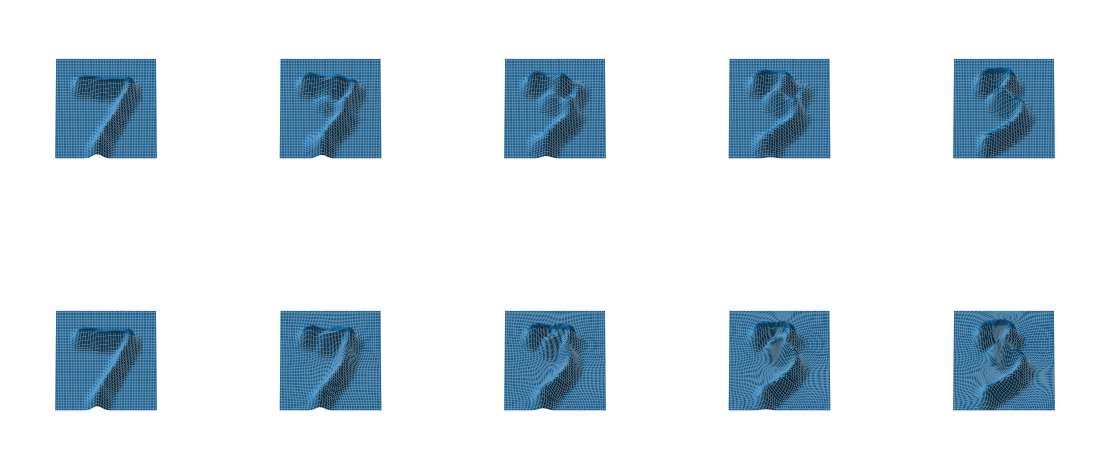

In [89]:
def interpolate(f, g, t):
    return lambda x: (1 - t) * f(x) + t * g(x)

def geodesics(f, g, steps=5):
    t = np.linspace(0, 1, steps)
    data = [None] * steps
    for i in range(steps):
        data[i] = interpolate(f, g, t[i])
        
    return data

with torch.no_grad():
    fig = plt.figure(figsize=(14, 6))
    for i, h in enumerate(geodesics(f, g)):
        ax = fig.add_subplot(2, 5, i+1, projection="3d")
        Z = h(X).view(k, k, 3).permute(2, 0, 1).detach().numpy()
        ax.plot_surface(*Z, rstride=1, cstride=1)
        ax.view_init(80, -270)
        ax.invert_yaxis()
        ax.set_axis_off()

    for i, h in enumerate(geodesics(f, lambda x: g(RN(x)))):
        ax = fig.add_subplot(2, 5, i+6, projection="3d")
        Z = h(X).view(k, k, 3).permute(2, 0, 1).detach().numpy()
        ax.plot_surface(*Z, rstride=1, cstride=1)
        ax.view_init(80, -270)
        ax.invert_yaxis()
        ax.set_axis_off()

    plt.show()

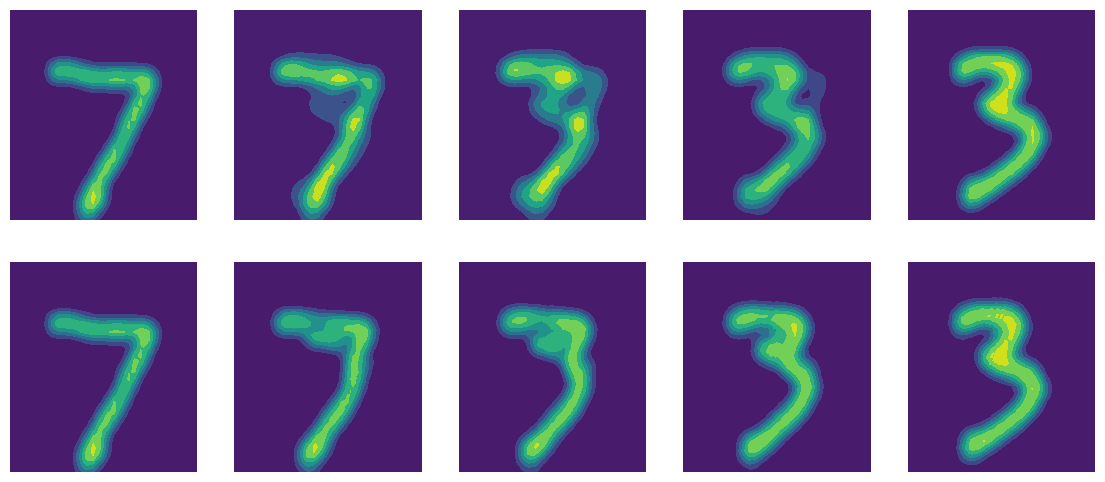

In [91]:
with torch.no_grad():
    fig = plt.figure(figsize=(14, 6))
    for i, h in enumerate(geodesics(f, g)):
        ax = fig.add_subplot(2, 5, i+1)
        Z = h(X).view(k, k, 3).permute(2, 0, 1).detach().numpy()
        ax.contourf(*Z)
        ax.invert_yaxis()
        ax.set_axis_off()

    for i, h in enumerate(geodesics(f, lambda x: g(RN(x)))):
        ax = fig.add_subplot(2, 5, i+6)
        Z = h(X).view(k, k, 3).permute(2, 0, 1).detach().numpy()
        ax.contourf(*Z)
        ax.invert_yaxis()
        ax.set_axis_off()

    plt.show()

In [92]:
s = ImageWarpDistance(k=64)
s(RN)

tensor(2.7738, grad_fn=<DivBackward0>)